# Sentinel-2 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
s2a_msil2a, 
s2b_msil2a


## Background

Sentinel-2 is an Earth observation mission from the EU Copernicus Programme that systematically acquires optical imagery at high spatial resolution (up to 10 m for some bands).
The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery.
Together, they cover all Earth's land surfaces, large islands, inland and coastal waters every 3-5 days.

Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.
Both of the Sentinel-2 satellites carry an innovative wide swath high-resolution multispectral imager with 13 spectral bands.
For more information on the Sentinel-2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Applications/Observing_the_Earth/Copernicus/Overview4).

Digital Earth Africa (DE Africa) applies corrections to Sentinel-2 satellite images to arrive at a [surface reflectance](https://cmi.ga.gov.au/ga_s2_m_nbart_1) product.
Surface reflectance provides standardised optical datasets by using robust physical models to correct for variations in image radiance values due to atmospheric properties, as well as sun and sensor geometry.
The resulting stack of surface reflectance grids are consistent over space and time, which is instrumental in identifying and quantifying environmental change.

DE Africa provides one Sentinel-2 surface reflectance product:

1. **Sentinel-2 Definitive** (e.g. `s2a_msil2a`): These products represent the 'definitive' source of high quality Sentinel-2 surface reflectance data, and are available from the beginning of the Sentinel-2 archive up to a delay of several weeks. 

Sentinel-2 surface reflectance products have 13 spectral channels:

| Sentinel-2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `blue` | 2 | 490 | 10 | 65 |
| Green | `green` | 3 | 560 | 10 | 35 |
| Red | `red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nir_1` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nir_2` | 8A | 865 | 20 | 20 |
| Water vapour | `water_vapour` | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `swir_1` | 11 | 1610 | 20 | 90 |
| SWIR | `swir_2` | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

!['Sentinel-2 spectral bands'](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)
     
> **Note**: There are a number of additional datasets that are also returned as part of Sentinel-2 queries.
These are a combination of datasets used in the correction process, and layers relating to pixel quality.

## Description

This notebook will run through loading in Sentinel-2A and Sentinel-2B satellite images.
Topics covered include:

* Using the native `dc.load()` function to load in Sentinel-2 Definitive data from a single Sentinel-2 satellite
* Using the `load_ard()` wrapper function to load in a concatenated, sorted, and cloud masked time series from both Sentinel-2A and 2B

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import sys
import datacube
from odc.ui import with_ui_cbk

sys.path.append("../Scripts")
from deafrica_datahandling import load_ard

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Sentinel_2")

## Load Sentinel-2 data from the datacube

We will load **Sentinel-2 Definitive** data from the Sentinel-2A and Sentinel-2B satellites using two methods.
Firstly, we will use [dc.load()](../Beginners_guide/03_Loading_data.ipynb) to return a time series of satellite images from a single sensor.
Secondly, we will load a time series using the [load_ard()](../Frequently_used_code/Using_load_ard.ipynb) function, which is a wrapper function around the dc.load module.
This function will load all the images from both Sentinel-2A and Sentinel-2B, combine them, and then apply a cloud mask.
The returned `xarray.Dataset` will contain analysis ready images with the cloudy and invalid pixels masked out.

You can change any of the parameters in the `query` object below to adjust the location, time, projection, or spatial resolution of the returned datasets.
To learn more about querying, refer to the Beginner's guide notebook on [loading data](../Beginners_guide/03_Loading_data.ipynb).

Sentinel-2 data is stored on file with a range of different coordinate reference systems or CRS (i.e. multiple UTM zones). 
The different satellite bands also have different resolutions (10 m, 20 m and 60 m). 
Because of this, all Sentinel-2 queries need to include the following two query parameters:

* `output_crs`: This sets a consistent CRS that all Sentinel-2 data will be reprojected to, regardless of the UTM zone the individual image is stored in.
* `resolution`: This sets the resolution that all Sentinel-2 images will be resampled to. 

> **Note:** Be aware that setting `resolution` to the highest available resolution (i.e. `(-10, 10)`) will downsample the coarser resolution 20 m and 60 m bands, which may introduce unintended artefacts into your analysis.
It is typically best practice to set `resolution` to match the lowest resolution band being analysed. For example, if your analysis uses both 10 m and 20 m resolution bands, set `"resolution": (-20, 20)`.

In [3]:
# Create a query object
query = {
    "latitude": (5.5135,5.5242),
    "longitude": (-0.3046,-0.2837),
    "time": ("2018-01", "2018-02"),
    "output_crs": "EPSG:4326",
    "resolution": (-89.8311175e-6, 89.8311175e-6),
    "group_by": "solar_day",
}

### Load Sentinel-2 using `dc.load()`

The two **Sentinel-2 Definitive** products are:

* `s2a_msil2a`
* `s2b_msil2a`

Here we will load in a time-series of satellite images from only Sentinel-2A.
To load in images from Sentinel-2B, change the `product` variable to `'s2b_msil2a'`.

In [4]:
ds = dc.load(product="s2a_msil2a",
             progress_cbk=with_ui_cbk(),
             **query)

print(ds)

<xarray.Dataset>
Dimensions:          (latitude: 120, longitude: 233, time: 12)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-02T10:33:57.706000 ... 2018-02-28T10:21:54.151000
  * latitude         (latitude) float64 5.524 5.524 5.524 ... 5.514 5.514 5.514
  * longitude        (longitude) float64 -0.3046 -0.3045 ... -0.2838 -0.2837
Data variables:
    coastal_aerosol  (time, latitude, longitude) uint16 791 766 ... 1957 1957
    blue             (time, latitude, longitude) uint16 967 968 ... 1242 1076
    green            (time, latitude, longitude) uint16 1284 1268 ... 1456 1354
    red              (time, latitude, longitude) uint16 1306 1314 ... 1554 1550
    red_edge_1       (time, latitude, longitude) uint16 1548 1535 ... 1821 1821
    red_edge_2       (time, latitude, longitude) uint16 1158 1243 ... 1745 1745
    red_edge_3       (time, latitude, longitude) uint16 1143 1200 ... 1733 1733
    nir_1            (time, latitude, longitude) uint16 1124 1166 ... 1188 10

The returned dataset contains all of the bands available for Sentinel-2.

In [5]:
bands = ["blue", "green", "red"]

ds = dc.load(product="s2a_msil2a",
             measurements=bands,
             progress_cbk=with_ui_cbk(),
             **query)

print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 120, longitude: 233, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-02T10:33:57.706000 ... 2018-02-28T10:21:54.151000
  * latitude   (latitude) float64 5.524 5.524 5.524 5.524 ... 5.514 5.514 5.514
  * longitude  (longitude) float64 -0.3046 -0.3045 -0.3044 ... -0.2838 -0.2837
Data variables:
    blue       (time, latitude, longitude) uint16 967 968 908 ... 1334 1242 1076
    green      (time, latitude, longitude) uint16 1284 1268 1240 ... 1456 1354
    red        (time, latitude, longitude) uint16 1306 1314 1314 ... 1554 1550
Attributes:
    crs:      EPSG:4326


Once the load is complete, we can then analyse or plot the Sentinel-2 data:

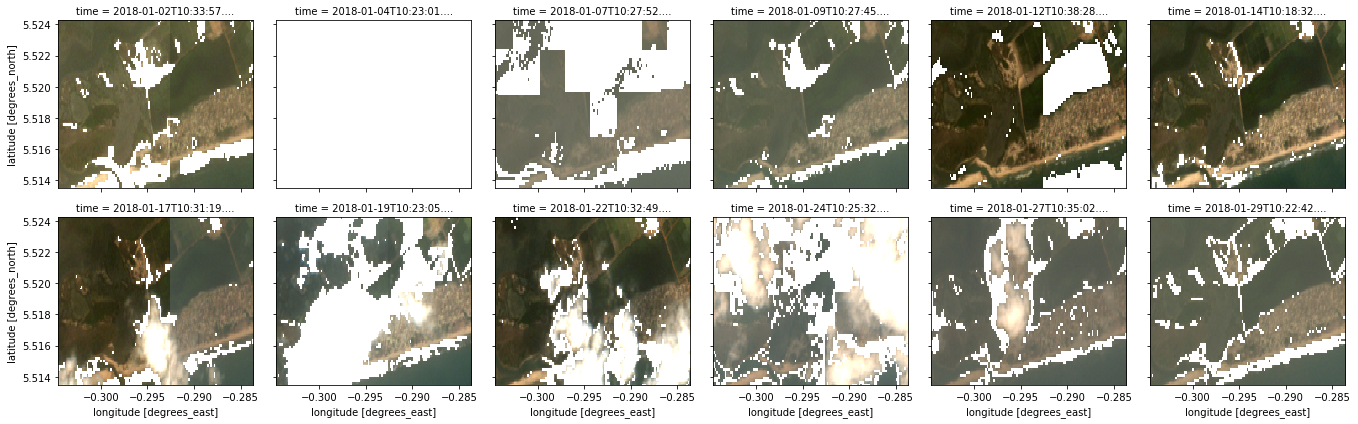

In [12]:
ds.isel(time=slice(0, 12))[['red', 'green', 'blue']].to_array().plot.imshow(col='time', col_wrap=6, vmin=0, vmax=3000);

### Load Sentinel-2 using `load_ard`

This function will load images from both Sentinel-2A and Sentinel-2B, concatenate and sort the observations by time, and apply a cloud mask.
The result is an analysis ready dataset.
You can find more information on this function from the [Using load ard](../Frequently_used_code/Using_load_ard.ipynb) notebook.

In [7]:
ds = load_ard(dc=dc,
              products=["s2a_msil2a", "s2b_msil2a"],
              measurements=bands,
              **query)

print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2a_msil2a
    s2b_msil2a
Applying pixel quality/cloud mask
Loading 23 time steps
<xarray.Dataset>
Dimensions:    (latitude: 120, longitude: 233, time: 23)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-02T10:33:57.706000 ... 2018-02-28T10:21:54.151000
  * longitude  (longitude) float64 -0.3046 -0.3045 -0.3044 ... -0.2838 -0.2837
  * latitude   (latitude) float64 5.524 5.524 5.524 5.524 ... 5.514 5.514 5.514
Data variables:
    blue       (time, latitude, longitude) float32 967.0 968.0 ... 1242.0 1076.0
    green      (time, latitude, longitude) float32 1284.0 1268.0 ... 1354.0
    red        (time, latitude, longitude) float32 1306.0 1314.0 ... 1550.0
Attributes:
    crs:      EPSG:4326


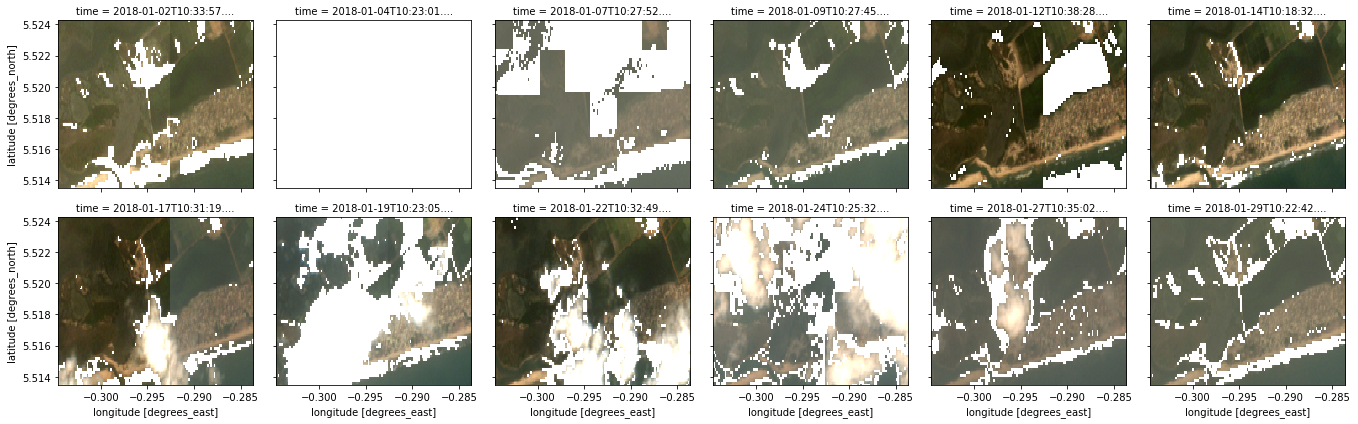

In [14]:
ds.isel(time=slice(0, 12))[['red', 'green', 'blue']].to_array().plot.imshow(col='time', col_wrap=6, vmin=0, vmax=3000);

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [9]:
print(datacube.__version__)

1.7+253.ga031f3f4.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)